In [64]:
%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
from pandas import *
import pandas as pd
import seaborn; seaborn.set()

# Import widget methods
from IPython.html.widgets import *

class Building_Occupants():
    
    """
    Occipant class, which encapsulates the entire behavior of an occupant in a building.
    
    """    
        
    def __init__ (self, model, occupant_id, user_type, energy_consumption, prob_hookup=0.5
                  ):
        """
        Constructor for Building_Occupants class
        By default,
        user_type = "Medium_User" i.e. medium energy user. 
    
        """
        self.model = model
        self.occupant_id = occupant_id
        self.user_type= user_type
        self.energy_consumption = energy_consumption
        self.prob_hookup = prob_hookup
        
    def decide_hookup(self):
        """
        Decide if we want to hookup with a potential partner.
        """
        if numpy.random.random() <= self.prob_hookup:
            return True
        else:
            return False
        
    def decide_impact(self):
        """
        Decide if the lesser energy user will impact the higher one
        """
        if (self.model.edu_Programs()):
            #print "True"
            return True
        else:
            #print "False"
            return False
    
    def get_position(self):
        """
        Return position, calling through model.
        """
        return self.model.get_person_position(self.occupant_id)
    
    def get_neighbors(self):
        """
        Return neighbors, calling through model.
        """
        return self.model.get_person_neighbors(self.occupant_id)

class Model(object):
    """
    Model class, which encapsulates the entire behavior of a single "run" in our HIV ABM.
    
    """
    def __init__(self,
                 grid_size, 
                 population_size, 
                 numOfYears,
                 low_users,
                 medium_users,
                 high_users,
                 wallMfreq, 
                 roofMfreq,
                 low_user_consume = 200,
                 medium_user_consume = 300,
                 high_user_consume = 400,
                 avg_Efficiency = 1,
                 total_energy = 30000,
                ):
        
        # Setting the model parameters;
        self.grid_size = grid_size
        self.population_size = population_size
        self.numOfYears = numOfYears
        self.low_users = low_users
        self.medium_users = medium_users
        self.high_users = high_users
        self.wallMfreq = wallMfreq
        self.roofMfreq = roofMfreq
        self.low_user_consume = low_user_consume
        self.medium_user_consume = medium_user_consume
        self.high_user_consume = high_user_consume
        self.avg_Efficiency = avg_Efficiency
        self.total_energy = total_energy
        self.high_users = self.population_size-self.low_users-self.medium_users
    # Setting the state variables
        self.occupants_list = []
        self.space = numpy.array((0,0))
        self.timeStep = 0
        self.num_interactions_impacts = 0
        self.num_interactions = 0
        self.bldgEfficiencyList = []
        
        self.history_space = []
        self.history_interactions = []
        self.history_num_interactions_impacts = []
        self.history_space_infected = []
        
        
    # Call our setup methods to initialize space and occupants.
        self.setup_space()        
        self.setup_occupants()
        #self.total_energy_conusmption()

    def setup_space(self):
        """
        Method to setup our space.
        """
        # Initialize a space with a NaN's
        self.space = numpy.full((self.grid_size, self.grid_size), numpy.nan)
    
    def setup_occupants(self):
        """
        Method to setup the occupants in the space
        """
        
        # First, begin by creating all the occupants without placing them.
        for occupant_id in range(self.population_size):
            if (occupant_id < self.low_users):
                self.occupants_list.append(Building_Occupants(self, 
                                                              occupant_id, 
                                                              user_type = "low_user",
                                                              energy_consumption = self.low_user_consume
                                                             )
                                          )
            if (occupant_id >= self.low_users and occupant_id < self.low_users + self.medium_users):
                self.occupants_list.append(Building_Occupants(self, 
                                                              occupant_id, 
                                                              user_type = "medium_user",
                                                              energy_consumption = self.medium_user_consume
                                                             )
                                          )
            elif (occupant_id >= self.low_users + self.medium_users):
                self.occupants_list.append(Building_Occupants(self, 
                                                              occupant_id, 
                                                              user_type = "high_user",
                                                              energy_consumption = self.high_user_consume
                                                             )
                                          )
        
        # After creating the occupants, place them into the space.
        for occupant in self.occupants_list:
            # Loop until unique
            is_occupied = True
            while is_occupied:
                # Sample location
                random_x = numpy.random.randint(0, self.grid_size)
                random_y = numpy.random.randint(0, self.grid_size)
                
                # Check if unique
                if numpy.isnan(self.space[random_x, random_y]):
                    is_occupied = False
                else:
                    is_occupied = True
            
            # Now place the person there by setting their ID.
            self.space[random_x, random_y] = occupant.occupant_id
    
        #print self.space
    
    def get_neighborhood(self, x, y, distance=1):
        """
        Get a Moore neighborhood of distance from (x, y).
        """
        neighbor_pos = [ ( x % self.grid_size, y % self.grid_size)
                                for x, y in itertools.product(xrange(x-distance, x+distance+1),
                                xrange(y-distance, y+distance+1))]
        return neighbor_pos
    
    def get_neighbors(self, x, y, distance=1):
        """
        Get any neighboring persons within distance from (x, y).
        """
        neighbor_pos = self.get_neighborhood(x, y, distance)
        neighbor_list = []
        for pos in neighbor_pos:
            # Skip identity
            if pos[0] == x and pos[1] == y:
                continue
                
            # Check if empty
            if not numpy.isnan(self.space[pos[0], pos[1]]):
                neighbor_list.append(int(self.space[pos[0], pos[1]]))
        
        return neighbor_list
    
    def get_occupant_position(self, occupant_id):
        """
        Get the position of a person based on their ID.
        """
        # Find the value that matches our ID in self.space, then reshape to a 2-element list.
        return numpy.reshape(numpy.where(m.space == occupant_id), (1, 2))[0].tolist()

    def get_occupant_neighbors(self, occupant_id, distance=1):
        """
        Get the position of a person based on their ID.
        """
        # Find the value that matches our ID in self.space, then reshape to a 2-element list.
        x, y = self.get_occupant_position(occupant_id)
        return self.get_neighbors(x, y, distance)  
    def move_occupant(self, occupant_id, x, y):
        """
        Move a person to a new (x, y) location.
        """
        
        # Get original
        original_position = self.get_occupant_position(occupant_id)
        
        # Check target location
        if not numpy.isnan(self.space[x, y]):
            raise ValueError("Unable to move person {0} to ({1}, {2}) since occupied.".format(occupant_id, x, y))
        
        # Otherwise, move by emptying and setting.
        self.space[original_position[0], original_position[1]] = numpy.nan
        self.space[x, y] = occupant_id
    
    def step_move(self):
        """
        Model step move function, which handles moving agents randomly around.
        """
        
        # Get a random order for the agents.
        random_order = range(self.population_size)
        numpy.random.shuffle(random_order)
        
        # Iterate in random order.
        for i in random_order:
            # Get current position
            x, y = self.get_occupant_position(i)
            
            # Move our agent between -1, 0, +1 in each dimension
            x_new = (x + numpy.random.randint(-1, 2)) % self.grid_size
            y_new = (y + numpy.random.randint(-1, 2)) % self.grid_size
            
            # Try to move them
            try:
                self.move_occupant(i, x_new, y_new)
            except ValueError:
                # Occupied, so fail.
                pass
        #print self.space
            
    def step_interact(self):
        """
        "Interact" the agents by seeing if they will hookup and spread.
        """
        
        # Get a random order for the agents.
        random_order = range(self.population_size)
        numpy.random.shuffle(random_order)
        
        # Track which pairs we've tested.  Don't want to "interact" them twice w/in one step.
        seen_pairs = []
        
        # Iterate in random order.
        for i in random_order:
            
            #self.history_interactions = []
            
            # Get neighbors
            neighbors = self.get_occupant_neighbors(i)
            
            # Iterate over neighbors
            for neighbor in neighbors:
                # Check if we've already seen.
                a = min(i, neighbor)
                b = max(i, neighbor)
                if (a, b) not in seen_pairs:
                    seen_pairs.append((a, b))
                else:
                    continue
                
                # Check if hookup if not seen.
                hookup_a = self.occupants_list[a].decide_hookup()
                hookup_b = self.occupants_list[b].decide_hookup()
                if hookup_a and hookup_b:
                    # Hookup going to happen.  
                    self.num_interactions += 1
                                        
                    # Check if the interactions have an impact (i.e. if the good users influence bad users or vice versa).
                    if self.occupants_list[a].decide_impact():
                        # there is a positive impact (good users influence bad users).
                        self.num_interactions_impacts += 1
                        did_impact = True
                        #no effect if same user types interact with each other

                        if self.occupants_list[a].user_type == "low_user" and self.occupants_list[b].user_type == "low_user":
                            pass
            
                        elif self.occupants_list[a].user_type == "medium_user" and self.occupants_list[b].user_type == "medium_user":
                            pass
                        elif self.occupants_list[a].user_type == "high_user" and self.occupants_list[b].user_type == "high_user":
                            pass

                        #if a low user user interact with medium user, medium user gets converted into low user. 
                        #if a high user interacts with low/medium user, high user converts into medium user. 
                        elif self.occupants_list[a].user_type == "low_user" or self.occupants_list[b].user_type == "low_user":
                            if self.occupants_list[a].user_type == "medium_user" or self.occupants_list[b].user_type == "medium_user":
                                self.occupants_list[a].user_type = self.occupants_list[b].user_type = "low_user" # change the user type
                                # update the number of users of each type after interaction
                                self.low_users += 1
                                self.medium_users = self.medium_users - 1
                                self.high_users = self.population_size - self.low_users - self.medium_users
                            else:
                                if self.occupants_list[a].user_type == "high_user":
                                    self.occupants_list[a].user_type = "medium_user" # change the user type
                                elif self.occupants_list[b].user_type == "high_user":    
                                    self.occupants_list[b].user_type = "medium_user" # change the user type
                                    # update the number of users of each type after interaction
                                self.medium_users += 1
                                self.high_users = self.population_size - self.low_users - self.medium_users
                        else: 
                            self.occupants_list[a].user_type = "medium_user" # change the user type
                            self.occupants_list[b].user_type = "medium_user" # change the user type
                            
                            # update the number of users of each type after interaction
                            self.medium_users += 1
                            self.high_users = self.population_size - self.low_users - self.medium_users
                    else:
                        did_impact = False
                        # there is a negative impact (bad users influence good users).
                        #self.num_interactions_impacts += 1
                        if self.occupants_list[a].user_type == "low_user" and self.occupants_list[b].user_type == "low_user":
                            pass
                        elif self.occupants_list[a].user_type == "medium_user" and self.occupants_list[b].user_type == "medium_user":
                            pass
                        elif self.occupants_list[a].user_type == "high_user" and self.occupants_list[b].user_type == "high_user":
                            pass
                        
                        elif self.occupants_list[a].user_type == "high_user" or self.occupants_list[b].user_type == "high_user":
                            if self.occupants_list[a].user_type == "medium_user" or self.occupants_list[b].user_type == "medium_user":
                                self.occupants_list[a].user_type = "high_users"
                                self.occupants_list[b].user_type = "high_user" 
                                self.medium_users = self.medium_users - 1
                                self.high_users = self.population_size - self.low_users - self.medium_users
                            elif self.occupants_list[a].user_type == "low_user" or self.occupants_list[b].user_type == "low_user":
                                if self.occupants_list[a].user_type == "low_user":
                                    self.occupants_list[a].user_type = "medium_user"
                                elif self.occupants_list[b].user_type == "low_user":
                                    self.occupants_list[b].user_type = "medium_user"
                                self.low_users = self.low_users - 1
                                self.medium_users = self.medium_users + 1
                                self.high_users = self.population_size - self.low_users - self.medium_users
                                
                        else:
                            self.occupants_list[a].user_type = "medium_user" 
                            self.occupants_list[b].user_type = "medium_user"
                            self.medium_users += 1
                            self.low_users = self.low_users - 1
                            self.high_users = self.population_size - self.low_users - self.medium_users
  
                    self.history_interactions.append((self.timeStep, a, b, 
                                                      did_impact,
                                                      self.occupants_list[a].user_type, 
                                                      self.occupants_list[b].user_type))
                        

    
    #-----------------------------------------------------------------------------------------------
    def bldgEfficiency_decrease(self):
        """
        This method generates the yearly decrease in building efficiency.
        A building's efficiency is determined by the systems efficiency and the material property variations 
        """
        syst_eff_dec = numpy.random.uniform(0.5,1.5) # Building systems normally have the biggest influence on the eff
        mat_eff_dec = numpy.random.uniform(0,0.5)
        
        bldg_eff_dec = syst_eff_dec + mat_eff_dec
        
        return bldg_eff_dec
    
    
    def bldgWalls_Maintenance(self):
        """
        This method generates increase in building efficiency due to maintenance of building walls
        """
        # The performance of a building enevelope is dependent upon the insulation property R- Value of the material 
        
        walls_Rvalue_inc = numpy.random.uniform(0.1,0.5)
        bldg_eff_inc_walls = 2*walls_Rvalue_inc 
        # The increase in building efficiency due to increase in R-Value is
        # is modelled as two times the R-Value increase. Normally this is a calculation done in the the energy simulation
        # software. For teh context of this project, it is modelled in a simple way.
        
        return bldg_eff_inc_walls
    
    def bldgRoofs_Maintenance(self):
        
        """
        This method generates increase in building efficiency due to maintenance of building roofs
        """
        # The performance of a building enevelope is dependent upon the insulation property R- Value of the material 
        
        roof_Rvalue_inc = numpy.random.uniform(0.1,0.5)
        bldg_eff_inc_roof = 2*roof_Rvalue_inc
        
         # The increase in building efficiency due to increase in R-Value is
        # is modelled as two times the R-Value increase. Normally this is a calculation done in the the energy simulation
        # software. For teh context of this project, it is modelled in a simple way.
        
        return bldg_eff_inc_roof
    
    def edu_Programs(self):
        """
        This function decides the frequency of educational awareness programs stochastically 
        """
        if (numpy.random.binomial(1,0.5)):
            return True
        else:
            return False
    # If the output cell value is 1, that means there is an educational progarm 
    # for that particular year
    
    def step(self):
        """
        Model step function. 
        """
    
       
        #print self.avg_Efficiency
        
        # "Interact" occupants.
        self.step_interact()
        
        # Move occupants
        self.step_move()
        
        # Increment steps and track history.
        self.timeStep += 1 #increment time!!
        self.history_space.append(copy.deepcopy(self.space))
        self.history_num_interactions_impacts.append(self.num_interactions_impacts)
        self.history_space_infected.append(self.get_space_infected())
        self.total_energy_conusmption()
        
        
    #---------------------------------------------------------------------------------
    
    
    def building_efficiency_factor(self,year):
        
        
        self.bldgEfficiencyList.append(100)
        
        for i in range(1,self.numOfYears):
            #print i 
            if i % self.wallMfreq ==0 and i % self.roofMfreq == 0 :
                self.bldgEfficiencyList.append (self.bldgEfficiencyList[i-1] - self.bldgEfficiency_decrease()+ self.bldgWalls_Maintenance()+ self.bldgRoofs_Maintenance())
                #print 'both' ## These print edstatements just for understanding and later remove
            elif i % self.wallMfreq == 0:    
                self.bldgEfficiencyList.append (self.bldgEfficiencyList[i-1] - self.bldgEfficiency_decrease()+ self.bldgWalls_Maintenance())
                #print 'only wall maintenance'
            elif i % self.roofMfreq == 0:    
                self.bldgEfficiencyList.append (self.bldgEfficiencyList[i-1] - self.bldgEfficiency_decrease()+ self.bldgRoofs_Maintenance())
                #print 'only roof maintenance'
            else:
                self.bldgEfficiencyList.append (self.bldgEfficiencyList[i-1] - self.bldgEfficiency_decrease())           
        
        self.avg_Efficiency =  sum(self.bldgEfficiencyList)/(100*self.numOfYears)
        #print self.bldgEfficiencyList
        return (self.bldgEfficiencyList[year]/100)
    
    def total_energy_conusmption(self):
        
        self.total_energy = self.low_users*self.low_user_consume +self.medium_users*self.medium_user_consume + self.high_users*self.high_user_consume

        
    def get_space_infected(self, t=None):
        """
        Return a projection of the space that shows which cells good and bad energy users.
        """
        if t == None:
            # Initialize empty
            infected_space = numpy.zeros_like(self.space)
            
            # Iterate over persons and set.
            for p in self.occupants_list:
                x, y = self.get_occupant_position(p.occupant_id)
                if p.user_type == "low_user":
                    infected_space[x, y] = +1
                elif p.user_type == "medium_user":
                    infected_space[x, y] = +3
                elif p.user_type == "high_user":
                    infected_space[x, y] = +5
            
            # Return
            return infected_space
        else:
            # Return historical step
            return self.history_space_infected[t]    
        
        

m = Model(grid_size = 10,
                  population_size = 30, 
                  numOfYears = 10, 
                  low_users = 15, 
                  medium_users = 5, 
                  high_users = 10,
                  wallMfreq = 2,
                  roofMfreq = 5
                 )

# Step over the model for a few steps

print m.space
#print m.building_efficiency_factor(1)

for i in xrange(10):
    # Step
    m.step()
    print((m.timeStep,
       m.low_users,
       m.medium_users,
       m.high_users,
       m.total_energy*m.building_efficiency_factor(i),
       m.history_interactions))
    m.history_interactions = [] # clear off the prevous timeStep values



[[  7.  nan  12.  nan  21.  10.  nan  24.   1.  nan]
 [ nan  26.  nan  nan  nan   5.  nan  nan  nan  nan]
 [ nan   4.  nan  nan  nan  nan  nan   6.  19.  nan]
 [ 16.  nan  nan  29.  nan  17.  nan  nan  nan   8.]
 [ nan  nan  20.  nan  nan   3.  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  18.  nan   0.]
 [ nan  14.  nan  nan  27.  nan   2.  nan  nan  22.]
 [ nan  nan   9.  nan  nan  25.  nan  nan  nan  13.]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
 [ 11.  15.  23.  nan  nan  nan  28.  nan  nan  nan]]
(1, 15, 6, 9, 8400, [(0, 25, 27, True, 'high_user', 'high_user'), (0, 4, 26, False, 'medium_user', 'high_user'), (0, 20, 29, False, 'high_user', 'high_user'), (0, 7, 15, True, 'low_user', 'low_user'), (0, 11, 15, False, 'low_user', 'low_user'), (0, 5, 21, True, 'low_user', 'medium_user')])
(2, 10, 12, 8, 8684.797479620906, [(1, 7, 12, True, 'low_user', 'low_user'), (1, 1, 15, True, 'low_user', 'low_user'), (1, 9, 14, True, 'low_user', 'low_user'), (1, 3, 17, False,

# Testing the model

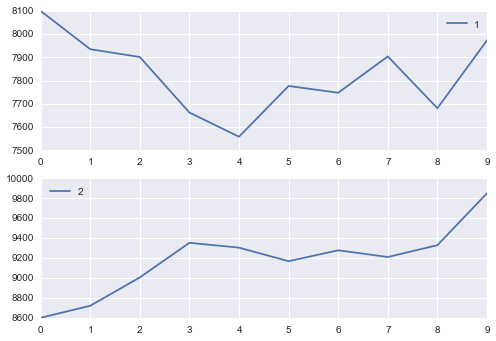

In [46]:
# Testing the model

# Scenario 1

history_total_energy_1 = []
m = Model(grid_size = 10,
                  population_size = 30, 
                  numOfYears = 10, 
                  low_users = 15, 
                  medium_users = 5, 
                  high_users = 10,
                  wallMfreq = 1,
                  roofMfreq = 1
                 )

# Step over the model for a few steps
for i in xrange(10):
    # Step
    m.step()
    history_total_energy_1.append(m.total_energy/m.building_efficiency_factor(i))
    
# Scenario 2

history_total_energy_2 = []

m = Model(grid_size = 10,
                  population_size = 30, 
                  numOfYears = 10, 
                  low_users = 15, 
                  medium_users = 5, 
                  high_users = 10,
                  wallMfreq = 5,
                  roofMfreq = 5
                 )

# Step over the model for a few steps
for i in xrange(10):
    # Step
    m.step()
    history_total_energy_2.append(m.total_energy/m.building_efficiency_factor(i))
    

# Plot time series.
f = plt.figure()
#Scenario 1
plt.subplot(211)
plt.plot(history_total_energy_1)
plt.legend(("1"), loc="best")
#Scenario 2
plt.subplot(212)
plt.plot(history_total_energy_2)
plt.legend(("2"), loc="best")


In [47]:

# Parameter Sweep values
history_total_energy = []
num_scenarios = 4


grid_size = 10
population_size = 30
numOfYears = 10 
low_users = 15
medium_users = 5
high_users = 10

wallMfreq_sweep = [2,4]
roofMfreq_sweep = [4,8]
sweep_output = []

# Iterate over low_users_sweep
for wallMfreq in wallMfreq_sweep:
    # Iterate over medium_user_sweep
    for roofMfreq in roofMfreq_sweep:
        print("Running {0} scenarios for low_users {1}, medium_users {2}"\
                  .format(num_scenarios, low_users, medium_users))
        for i in xrange(10):
            m = Model(grid_size,
                  population_size, 
                  numOfYears, 
                  low_users, 
                  medium_users, 
                  high_users,
                  wallMfreq,
                  roofMfreq 
                 )
            m.step()
        
            history_total_energy.append(m.total_energy/m.building_efficiency_factor(i))
        avg_energy_consumption = sum(history_total_energy)/m.numOfYears
        #generate the output
        sweep_output.append([m.wallMfreq,m.roofMfreq,avg_energy_consumption])

#printout the values and check
#print sweep_output
pd.DataFrame(sweep_output,columns=['wall_Maint_Freq','roof_Maint_Freq','Total_Energy_Consumption'])


Running 4 scenarios for low_users 15, medium_users 5
Running 4 scenarios for low_users 15, medium_users 5
Running 4 scenarios for low_users 15, medium_users 5
Running 4 scenarios for low_users 15, medium_users 5


,wall_Maint_Freq,roof_Maint_Freq,Total_Energy_Consumption
0,2,4,8809.181939
1,2,8,17670.091783
2,4,4,26626.497587
3,4,8,35651.815435


# Visulaizing the space

<function __main__.plot_occupants_types_in_space>

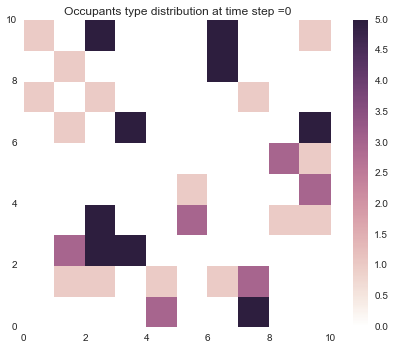

In [67]:
# get color map

cmap = seaborn.cubehelix_palette(light=1, as_cmap=True)

def plot_occupants_types_in_space(t=None):
        """
        Return a projection of the space that shows which cells have an infected person.
        """
        f = plt.figure()
        plt.title("Occupants type distribution at time step ={0}".format(t))
        plt.pcolor(m.get_space_infected(t), vmin=0, vmax=5, cmap=cmap)
        ax = f.gca()
        ax.set_aspect(1./ax.get_data_ratio())   
        plt.colorbar()
        
interact(plot_occupants_types_in_space,
                t=IntSlider(min=0, max=m.timeStep - 1, step=1))

In [12]:
#testing
occupants_list = ["low_user","medium_user","high_user"]
a=1
b=2

if occupants_list[a] == "low_user" or occupants_list[b] == "low_user":
    occupants_list[a] = occupants_list[b]= "low_user"
elif occupants_list[a] == "medium_user" or occupants_list[b] == "medium_user":
    occupants_list[a] = occupants_list[b] = "medium_user"
print occupants_list

['low_user', 'medium_user', 'medium_user']


In [67]:
# testing

for i in xrange(10):
    print numpy.random.binomial(1,0.5) 

1
1
1
1
0
1
0
0
1
0


In [3]:
#testing the good impact case
low_users = 6
medium_users = 5
high_users = 9
population_size = low_users+medium_users+high_users

l = "low_user"
m = "medium_user"
h = "high_user"

occupants_list = [h,l]

a = 0
b = 1

#no effect if same user types interact with each other

if occupants_list[a] == "low_user" and occupants_list[b] == "low_user":
    pass
    
elif occupants_list[a] == "medium_user" and occupants_list[b] == "medium_user":
    pass
elif occupants_list[a] == "high_user" and occupants_list[b] == "high_user":
    pass

#if a low user user interact with medium user, medium user gets converted into low user. 
#if a high user interacts with low/medium user, high user converts into medium user. 
elif occupants_list[a] == "low_user" or occupants_list[b] == "low_user":
    if occupants_list[a] == "medium_user" or occupants_list[b] == "medium_user":
        occupants_list[a] = occupants_list[b] = "low_user" # change the user type
        # update the number of users of each type after interaction
        low_users += 1
        medium_users = medium_users - 1
        high_users = population_size - low_users - medium_users
    else:
        if occupants_list[a] == "high_user":
            occupants_list[a] = "medium_user" # change the user type
        elif occupants_list[b] == "high_user":    
            occupants_list[b] = "medium_user" # change the user type
        # update the number of users of each type after interaction
        medium_users += 1
        high_users = population_size - low_users - medium_users
else:
    occupants_list[a] = occupants_list[b] = "medium_user" # change the user type
    # update the number of users of each type after interaction
    medium_users += 1
    high_users = population_size - low_users - medium_users

print (occupants_list[a], occupants_list[b])
print ((low_users,medium_users,high_users))
            

('medium_user', 'low_user')
(6, 6, 8)


In [4]:

#testing the bad impact case
low_users = 6
medium_users = 5
high_users = 9
population_size = low_users+medium_users+high_users

l = "low_user"
m = "medium_user"
h = "high_user"

occupants_list = [l,h]

a = 0
b = 1

if occupants_list[a] == "low_user" and occupants_list[b] == "low_user":
    pass
elif occupants_list[a] == "medium_user" and occupants_list[b] == "medium_user":
    pass
elif occupants_list[a] == "high_user" and occupants_list[b] == "high_user":
    pass
                        
elif occupants_list[a] == "high_user" or occupants_list[b] == "high_user":
    if occupants_list[a] == "medium_user" or occupants_list[b] == "medium_user":
        occupants_list[a] = "high_users"
        occupants_list[b] = "high_user" 
        medium_users = medium_users - 1
        high_users = population_size - low_users - medium_users
    elif occupants_list[a] == "low_user" or occupants_list[b] == "low_user":
        if occupants_list[a] == "low_user":
            occupants_list[a] = "medium_user"
        elif occupants_list[b] == "low_user":
            occupants_list[b] = "medium_user"
        low_users = low_users - 1
        medium_users = medium_users + 1
        high_users = population_size - low_users - medium_users
                               
else:
    occupants_list[a] = "medium_user" 
    occupants_list[b] = "medium_user"
    medium_users += 1
    low_users = low_users - 1
    high_users = population_size - low_users - medium_users

print (occupants_list[a], occupants_list[b])
print ((low_users,medium_users,high_users))
  

('medium_user', 'high_user')
(5, 6, 9)


In [52]:
# testing the space

print m.space

print m.space[0][0]
print m.space[1][0]
print m.space[3][0]


[[ nan   9.  21.  nan   8.  nan  nan  nan  nan  nan]
 [ nan  nan  nan  26.  nan  nan  17.  nan  nan  nan]
 [ nan  nan   6.  23.  18.  nan  nan  nan  nan  27.]
 [ 25.  nan  nan  20.  nan  nan  nan  nan  nan  nan]
 [ nan  12.  nan  nan  29.  nan  nan  nan  nan  nan]
 [ nan   0.  nan  nan   5.  nan  nan  15.  14.   3.]
 [ nan  nan  13.  22.  nan  nan  nan  nan  19.  nan]
 [ 10.  nan  nan  nan  nan  nan  16.  nan  nan  nan]
 [ nan   1.   2.  nan  nan  11.  nan  nan  28.  24.]
 [ nan  nan  nan  nan  nan  nan   4.  nan   7.  nan]]
nan
nan
25.0
